In [1]:
import pandas as pd
import numpy as np

### 1. Sample description

#### The target variable is d(basis) which denotes the weekly change of basis. The corresponding features of d(basis) at time t are data at time t-1.

In [2]:
#import data
df = pd.read_excel('c:/Users/cjyjy/Desktop/basis.xlsx',sheetname='weekly data',sep='')
df.head()

,Date,d(baisis),$index,VIX,TED,LIBOROIS,revyankee,solvency risk
0,2017-04-07,0.500,1223.05,12.37,39.53912,21.60,3991,-0.10
1,2017-03-31,3.125,1219.71,12.96,38.69363,23.20,1136,-0.12
2,2017-03-24,3.375,1227.49,11.28,42.30487,24.06,3511,-0.17
3,2017-03-17,-3.750,1243.81,11.66,37.72263,23.13,10059,-0.13
4,2017-03-10,2.125,1242.22,10.96,40.09200,25.07,4559,-0.20


#### we can see form the graph below that the changes of 2yr EURUSD basis was very small before 2007, extrmely large at 2008-2009(global financial crisis)  and 2010-2012(European sovereign debt crisis) and have remain volatile since then.

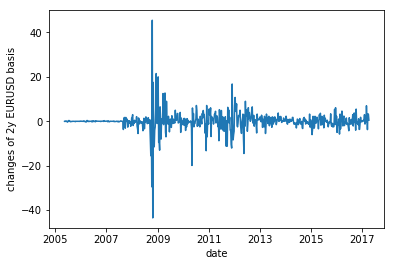

In [3]:
#plot the weekly changes of 2yr EURUSD basis from May 2005 to March 2017
import matplotlib.pyplot as plt

plt.plot(df.iloc[:,0].values,df.iloc[:,1].values)
plt.xlabel('date')
plt.ylabel('changes of 2y EURUSD basis')
plt.show()

In [4]:
#data description
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
d(baisis),622.0,-0.051527,4.443708,-43.50000,-1.000000,0.00000,1.000000,45.50000
$index,622.0,1047.785145,88.051937,905.95000,987.815000,1021.99500,1080.780000,1273.42000
VIX,622.0,19.305289,9.543019,10.02000,13.105000,16.42000,22.507500,79.13000
TED,622.0,47.880144,48.763416,10.55488,22.464692,32.55119,47.598733,463.10999
LIBOROIS,622.0,29.742122,37.519968,3.67000,11.680000,15.52500,32.980000,364.42000
revyankee,622.0,859.614148,1693.975358,0.00000,0.000000,27.00000,899.000000,12758.00000
solvency risk,622.0,0.424984,0.821312,-0.76000,-0.110000,0.27000,0.740000,3.60000


## 2.Predicting continuous target variables

#### From the scatter plot and correlation matrix, no significant relationship between changes of basis and any feature can be found.  Algorithms about continuous target variables like linear regression probably won't get satisfying outcomes.

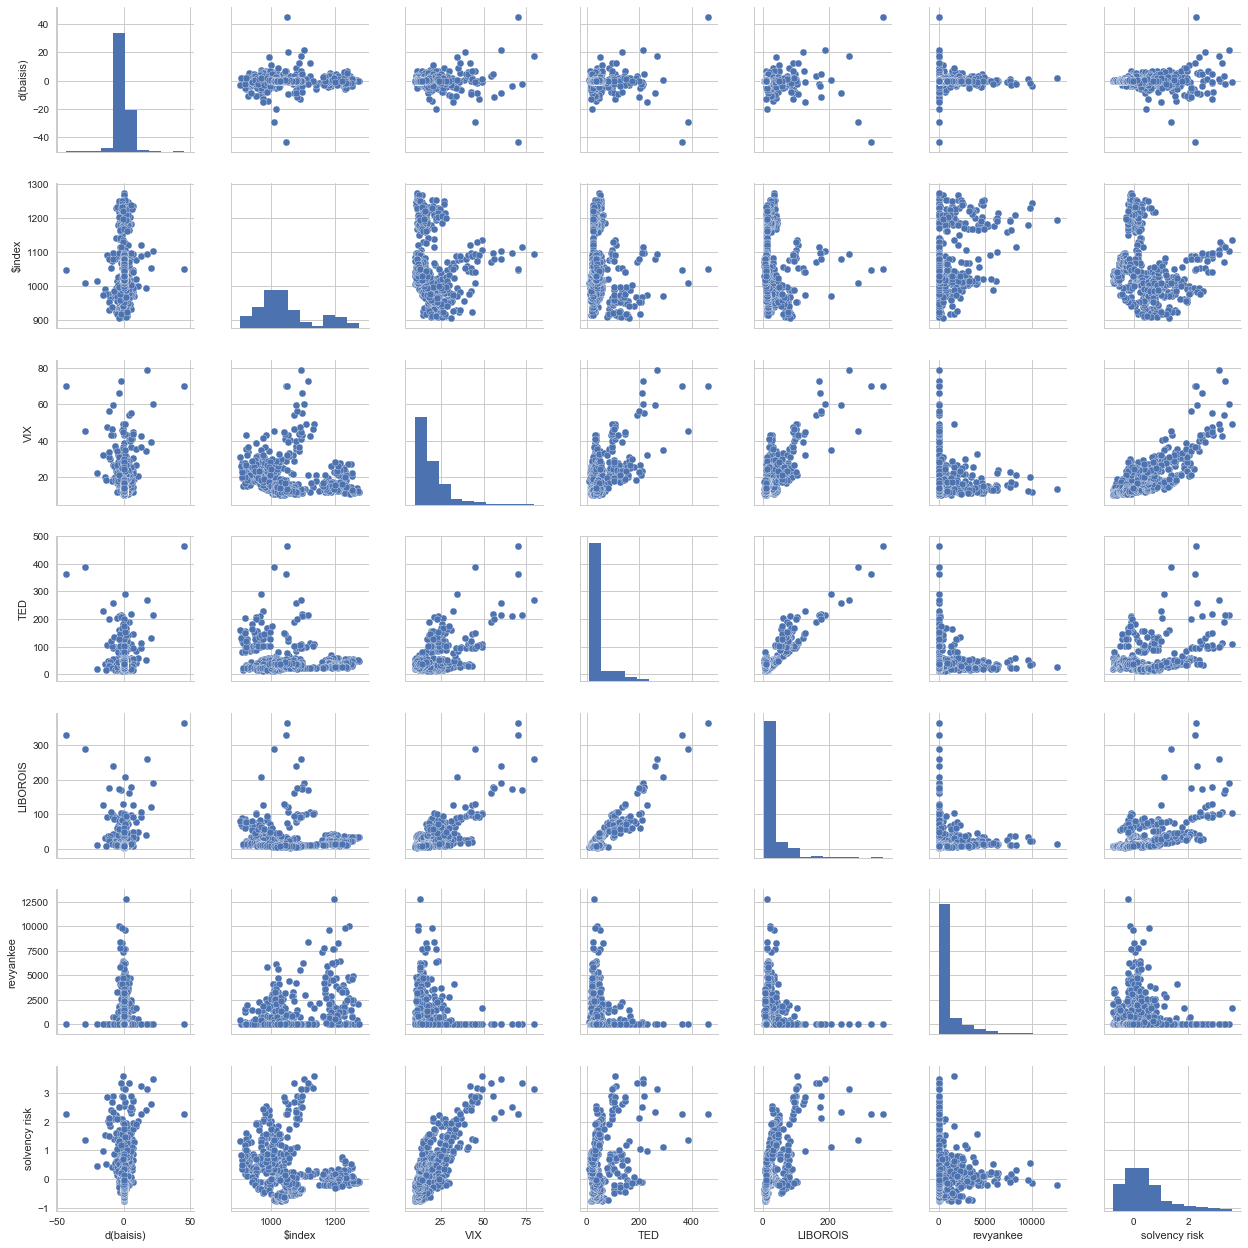

In [5]:
#scatter plot

import seaborn as sns

sns.set(style='whitegrid', context='notebook')
cols =list(df.columns[1:])

sns.pairplot(df, size=2.5)
plt.tight_layout()
plt.show()

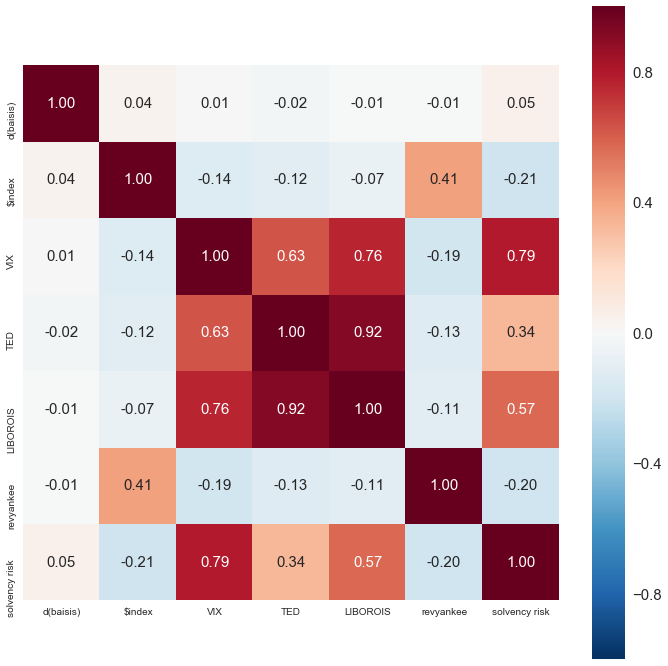

In [6]:
#plot the correlation matrix
plt.subplots(1, 1, figsize=(12, 12), sharex=True)
cm = np.corrcoef(df.iloc[:,1:].values.T)
sns.set(font_scale=1.5)
hm = sns.heatmap(cm, cbar=True, annot=True, 
                 square=True, fmt='.2f', annot_kws={'size': 15},
                 yticklabels=list(df.columns[1:]), xticklabels=list(df.columns[1:]))
plt.show()

#### Train a random forest regression model with continuous target variables, and then get a negative R square, which indicates that the model is quite overfitting.

In [7]:
#define target variabel and features, and split the data set into training set and test set

from sklearn.model_selection import train_test_split

y = df.iloc[:,1].values
X = df.iloc[:,2:].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [8]:
#random forest regression 

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

forest = RandomForestRegressor(n_estimators=1000, 
                               criterion='mse', 
                               random_state=1, 
                               n_jobs=-1)
forest.fit(X_train, y_train)
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)

print('R^2 train: %.3f, test: %.3f' % (r2_score(y_train, y_train_pred), r2_score(y_test, y_test_pred)))

R^2 train: 0.822, test: -0.355


## 3.Predicting labeled target variables

#### Try algorithms of predicting labeled target variables in the following part, since prediction of continuous target variables can't get a satisfying outcome.

In [9]:
#encode the lable. when basis goes up(down), y=0(1)
from sklearn.preprocessing import LabelEncoder

y=(df.iloc[:,1].values<0)
le = LabelEncoder()
y = le.fit_transform(y)
le.transform([True, False])

array([1, 0], dtype=int64)

In [10]:
#split data set 
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

### Try random forest, KNN, logistic regression and support vector machine respctively. Firstly, find best parameters via GridSearch. Secondly, 

#### The accuricies are all between 0.5 and 0.6, very low. And there is slightly underfitting in knn and logistic regression.

In [11]:
#tuning the parameters via gridsearch

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.cross_validation import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

forest = RandomForestClassifier(criterion='entropy',random_state=0)
knn = KNeighborsClassifier(p=2, metric='minkowski')
lr=LogisticRegression(random_state=0)
svm = SVC(random_state=0)


forest_param_range = np.arange(5,30)
forest_param_grid = [{'clf__n_estimators': forest_param_range}]

knn_param_range = np.arange(3,15)
knn_param_grid = [{'clf__n_neighbors': knn_param_range}]

lr_param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0]
lr_param_grid = [{'clf__C': lr_param_range}]

svm_param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
svm_param_grid = [{'clf__C': svm_param_range, 
               'clf__kernel': ['linear']},
                 {'clf__C': svm_param_range, 
                  'clf__gamma': svm_param_range, 
                  'clf__kernel': ['rbf']}]
for clf,clfname,param_grid in zip([forest, knn, lr, svm],['forest','knn','logistic regression','svm'], 
                                  [forest_param_grid, knn_param_grid,lr_param_grid,svm_param_grid]):
    if clf != forest:
        pipe = Pipeline([('scl', StandardScaler()), ('clf', clf)])
        pipe_pca = Pipeline([('scl', StandardScaler()), ('pca', PCA(n_components=2)),('clf', clf)])
    else:
        pipe = Pipeline([('clf', clf)])
        pipe_pca = Pipeline([('pca', PCA(n_components=2)),('clf', clf)])
        
    gs = GridSearchCV(estimator=pipe, 
                      param_grid=param_grid,
                      scoring='accuracy',
                      cv=10)
    gs_pca = GridSearchCV(estimator=pipe_pca, 
                      param_grid=param_grid,
                      scoring='accuracy',
                      cv=10)
    gs = gs.fit(X_train, y_train)
    gs_pca = gs_pca.fit(X_train, y_train)
    print('%s(without pca/with pca):\n      best score:%.3f/%.3f;\n      test accuracy:%.3f/%.3f;\n      best params:%r/%r'
          %(clfname, gs.best_score_, gs_pca.best_score_, gs.score(X_test, y_test),
            gs_pca.score(X_test, y_test), gs.best_params_, gs_pca.best_params_))


C:\Users\cjyjy\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


forest(without pca/with pca):
      best score:0.569/0.571;
      test accuracy:0.512/0.528;
      best params:{'clf__n_estimators': 14}/{'clf__n_estimators': 8}
knn(without pca/with pca):
      best score:0.577/0.545;
      test accuracy:0.584/0.632;
      best params:{'clf__n_neighbors': 12}/{'clf__n_neighbors': 4}
logistic regression(without pca/with pca):
      best score:0.575/0.561;
      test accuracy:0.528/0.592;
      best params:{'clf__C': 10.0}/{'clf__C': 1.0}
svm(without pca/with pca):
      best score:0.577/0.567;
      test accuracy:0.568/0.536;
      best params:{'clf__C': 100.0, 'clf__gamma': 0.1, 'clf__kernel': 'rbf'}/{'clf__C': 1000.0, 'clf__gamma': 0.001, 'clf__kernel': 'rbf'}


#### cross-validation accuracy

In [13]:
# use the parameters above.

forest = RandomForestClassifier(criterion='entropy',
                                n_estimators=14, 
                                random_state=1)
knn = KNeighborsClassifier(n_neighbors=12, p=2, metric='minkowski')
lr=LogisticRegression(C=10.0, random_state=1)
svm = SVC(kernel='rbf', random_state=1, gamma=0.1, C=100.0)

scores=[]

for clf,clfname in zip([forest, knn, lr, svm],['forest','knn','logistic regression','svm']):
    if clf != forest:
        pipe = Pipeline([('scl', StandardScaler()), ('clf', clf)])
    else:
        pipe = Pipeline([('clf', clf)])
        
    scores = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=10, n_jobs=1)
    print('CV Accuracy（%s）: %.3f+/-%.3f' % (clfname,np.mean(scores), np.std(scores)))

CV Accuracy（forest）: 0.540+/-0.062
CV Accuracy（knn）: 0.586+/-0.052
CV Accuracy（logistic regression）: 0.576+/-0.066
CV Accuracy（svm）: 0.515+/-0.027


### Due to the accuracies above are not high, add in a feature -- d(basis)-1, which denotes changes of basis at time t-1, to see whether accuracies can be improved.

In [14]:
#import new data
df = pd.read_excel('c:/Users/cjyjy/Desktop/basis.xlsx',sheetname='weekly data2',sep='')
df.head()

,Date,d(baisis),d(baisis)-1,$index,VIX,TED,LIBOROIS,revyankee,solvency risk
0,2017-04-07,0.500,3.125,1223.05,12.37,39.53912,21.60,3991,-0.10
1,2017-03-31,3.125,3.375,1219.71,12.96,38.69363,23.20,1136,-0.12
2,2017-03-24,3.375,-3.750,1227.49,11.28,42.30487,24.06,3511,-0.17
3,2017-03-17,-3.750,2.125,1243.81,11.66,37.72263,23.13,10059,-0.13
4,2017-03-10,2.125,7.000,1242.22,10.96,40.09200,25.07,4559,-0.20


#### Repeat the steps above and no significant improvement is observed.

In [16]:
#encoding the lable, when basis goes up(down), y=0(1)
from sklearn.preprocessing import LabelEncoder
X = df.iloc[:,2:].values
y=(df.iloc[:,1].values<0)
le = LabelEncoder()
y = le.fit_transform(y)

#split data set 
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


#GridSearch
forest_param_range = np.arange(5,30)
forest_param_grid = [{'clf__n_estimators': forest_param_range}]

knn_param_range = np.arange(3,15)
knn_param_grid = [{'clf__n_neighbors': knn_param_range}]

lr_param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0]
lr_param_grid = [{'clf__C': lr_param_range}]

svm_param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
svm_param_grid = [{'clf__C': svm_param_range, 
               'clf__kernel': ['linear']},
                 {'clf__C': svm_param_range, 
                  'clf__gamma': svm_param_range, 
                  'clf__kernel': ['rbf']}]
for clf,clfname,param_grid in zip([forest, knn, lr, svm],['forest','knn','logistic regression','svm'], 
                                  [forest_param_grid, knn_param_grid,lr_param_grid,svm_param_grid]):
    if clf != forest:
        pipe = Pipeline([('scl', StandardScaler()), ('clf', clf)])
        pipe_pca = Pipeline([('scl', StandardScaler()), ('pca', PCA(n_components=2)),('clf', clf)])
    else:
        pipe = Pipeline([('clf', clf)])
        pipe_pca = Pipeline([('pca', PCA(n_components=2)),('clf', clf)])
        
    gs = GridSearchCV(estimator=pipe, 
                      param_grid=param_grid,
                      scoring='accuracy',
                      cv=10)
    gs_pca = GridSearchCV(estimator=pipe_pca, 
                      param_grid=param_grid,
                      scoring='accuracy',
                      cv=10)
    gs = gs.fit(X_train, y_train)
    gs_pca = gs_pca.fit(X_train, y_train)
    print('%s(without pca/with pca):\n      best score:%.3f/%.3f;\n      test accuracy:%.3f/%.3f;\n      best params:%r/%r'
          %(clfname, gs.best_score_, gs_pca.best_score_, gs.score(X_test, y_test),
            gs_pca.score(X_test, y_test), gs.best_params_, gs_pca.best_params_))

forest(without pca/with pca):
      best score:0.535/0.549;
      test accuracy:0.560/0.528;
      best params:{'clf__n_estimators': 10}/{'clf__n_estimators': 28}
knn(without pca/with pca):
      best score:0.606/0.567;
      test accuracy:0.552/0.568;
      best params:{'clf__n_neighbors': 14}/{'clf__n_neighbors': 3}
logistic regression(without pca/with pca):
      best score:0.569/0.547;
      test accuracy:0.592/0.616;
      best params:{'clf__C': 0.01}/{'clf__C': 1.0}
svm(without pca/with pca):
      best score:0.581/0.577;
      test accuracy:0.568/0.592;
      best params:{'clf__C': 100.0, 'clf__gamma': 1.0, 'clf__kernel': 'rbf'}/{'clf__C': 1.0, 'clf__gamma': 10.0, 'clf__kernel': 'rbf'}


In [22]:
# use the parameters above.

forest = RandomForestClassifier(criterion='entropy',
                                n_estimators=10, 
                                random_state=1)
knn = KNeighborsClassifier(n_neighbors=14, p=2, metric='minkowski')
lr=LogisticRegression(C=0.01, random_state=1)
svm = SVC(kernel='rbf', random_state=1, gamma=1.0, C=100.0)

scores=[]

for clf,clfname in zip([forest, knn, lr, svm],['forest','knn','logistic regression','svm']):
    if clf != forest:
        pipe = Pipeline([('scl', StandardScaler()), ('clf', clf)])
    else:
        pipe = Pipeline([('clf', clf)])
        
    scores = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=10, n_jobs=1)
    print('CV Accuracy（%s）: %.3f+/-%.3f' % (clfname,np.mean(scores), np.std(scores)))

CV Accuracy（forest）: 0.536+/-0.080
CV Accuracy（knn）: 0.598+/-0.052
CV Accuracy（logistic regression）: 0.562+/-0.061
CV Accuracy（svm）: 0.533+/-0.004


In [18]:
#try bagging and adaboost classifier
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import AdaBoostClassifier

for clf,clfname in zip([forest, knn, lr, svm],['forest','knn','logistic regression','svm']):
    bag = BaggingClassifier(base_estimator=clf,
                            n_estimators=500, 
                            max_samples=1.0, 
                            max_features=1.0, 
                            bootstrap=True, 
                            bootstrap_features=False, 
                            n_jobs=1, 
                            random_state=1)

    
    if clf == forest or clf == lr:
        ada = AdaBoostClassifier(base_estimator=clf,
                             n_estimators=500, 
                             learning_rate=0.1,
                             random_state=1)
        
        bag = bag.fit(X_train, y_train)
        y_train_pred1 = bag.predict(X_train)
        y_test_pred1 = bag.predict(X_test)

        bag_train = accuracy_score(y_train, y_train_pred1) 
        bag_test = accuracy_score(y_test, y_test_pred1) 
    
        ada = ada.fit(X_train, y_train)
        y_train_pred2 = ada.predict(X_train)
        y_test_pred2 = ada.predict(X_test)

        ada_train = accuracy_score(y_train, y_train_pred2) 
        ada_test = accuracy_score(y_test, y_test_pred2) 
        print('[%s]\n Bagging train/test accuracies %.3f/%.3f \n AdaBoost train/test accuracies %.3f/%.3f'
              % (clfname,bag_train, bag_test, ada_train, ada_test))
    else:
        bag = bag.fit(X_train, y_train)
        y_train_pred1 = bag.predict(X_train)
        y_test_pred1 = bag.predict(X_test)

        bag_train = accuracy_score(y_train, y_train_pred1) 
        bag_test = accuracy_score(y_test, y_test_pred1) 
     
        print('[%s]\n Bagging train/test accuracies %.3f/%.3f'
              % (clfname,bag_train, bag_test))

[forest]
 Bagging train/test accuracies 0.998/0.536 
 AdaBoost train/test accuracies 1.000/0.520
[knn]
 Bagging train/test accuracies 0.646/0.552
[logistic regression]
 Bagging train/test accuracies 0.555/0.552 
 AdaBoost train/test accuracies 0.563/0.544
[svm]
 Bagging train/test accuracies 1.000/0.608


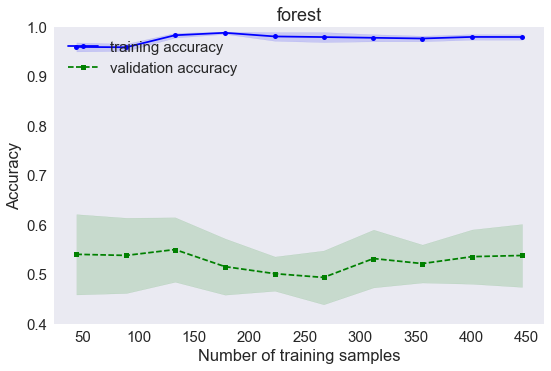

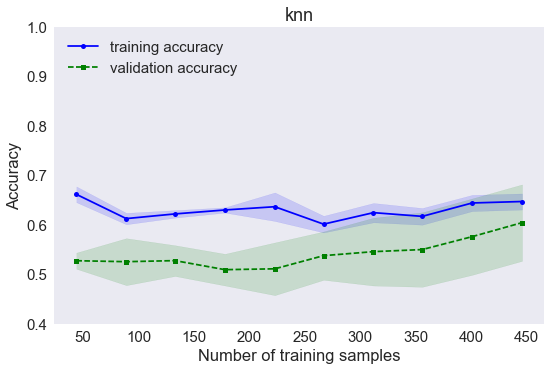

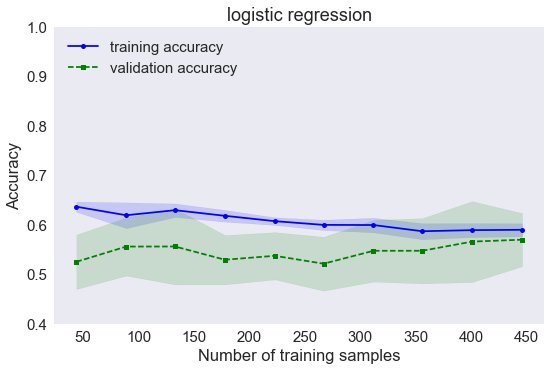

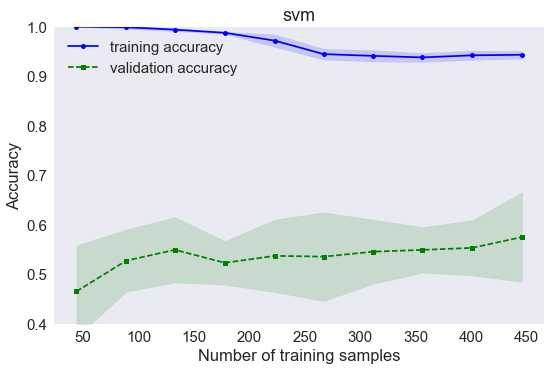

In [20]:
#learning curve
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

for clf,clfname in zip([forest, knn, lr, svm],['forest','knn','logistic regression','svm']):
    if clf == forest:
        pipe = Pipeline([('clf', clf)])
    else:
        pipe = Pipeline([('scl', StandardScaler()), ('clf', clf)])
    
    train_sizes, train_scores, test_scores =\
                learning_curve(estimator=pipe,
                               X=X_train,
                               y=y_train,
                               train_sizes=np.linspace(0.1, 1.0, 10),
                               cv=10,
                               n_jobs=1)

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    plt.plot(train_sizes, train_mean,
             color='blue', marker='o',
             markersize=5, label='training accuracy')

    plt.fill_between(train_sizes,
                     train_mean + train_std,
                     train_mean - train_std,
                     alpha=0.15, color='blue')

    plt.plot(train_sizes, test_mean,
             color='green', linestyle='--',
             marker='s', markersize=5,
             label='validation accuracy')

    plt.fill_between(train_sizes,
                     test_mean + test_std,
                     test_mean - test_std,
                     alpha=0.15, color='green')

    plt.grid()
    plt.title(clfname)
    plt.xlabel('Number of training samples')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper left')
    plt.ylim([0.4, 1.0])
    plt.tight_layout()
    plt.show()

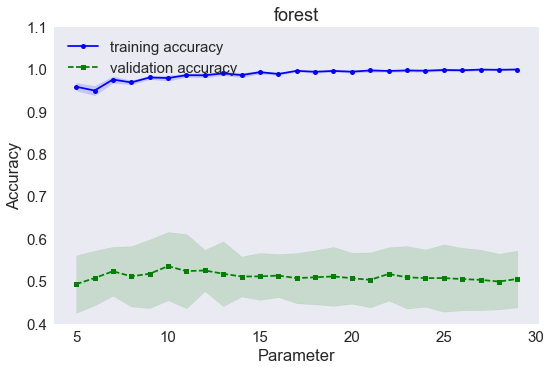

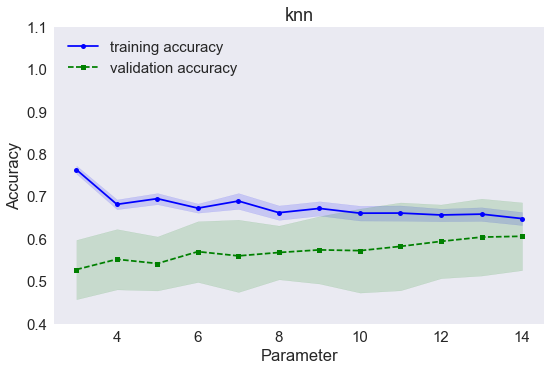

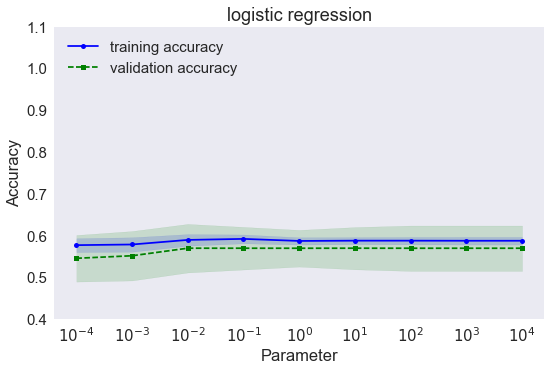

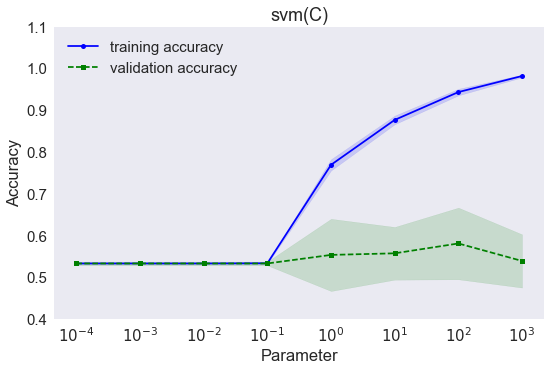

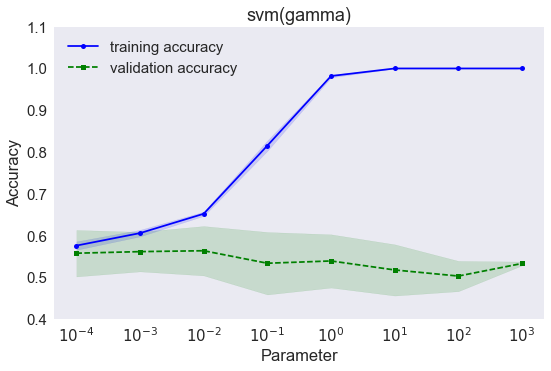

In [23]:
#validation curve
from sklearn.model_selection import validation_curve

forest_param_range = np.arange(5,30)

knn_param_range = np.arange(3,15)

lr_param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0]

svm_param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0] 
                  
for clf,clfname,param_range, param_name in zip([forest, knn, lr, svm, svm],['forest','knn','logistic regression','svm(C)','svm(gamma)'], 
                                               [forest_param_range, knn_param_range,lr_param_range,svm_param_range, svm_param_range],
                                               ['clf__n_estimators', 'clf__n_neighbors','clf__C', 'clf__C','clf__gamma']):
    if clf != forest:
        pipe = Pipeline([('scl', StandardScaler()), ('clf', clf)])
        
    else:
        pipe = Pipeline([('clf', clf)])
    
    
    train_scores, test_scores = validation_curve(estimator=pipe,
                                                 X=X_train, 
                                                 y=y_train, 
                                                 param_name=param_name, 
                                                 param_range=param_range,
                                                 cv=10)

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    plt.plot(param_range, train_mean, 
             color='blue', marker='o', 
             markersize=5, label='training accuracy')

    plt.fill_between(param_range, train_mean + train_std,
                     train_mean - train_std, alpha=0.15,
                     color='blue')

    plt.plot(param_range, test_mean, 
             color='green', linestyle='--', 
             marker='s', markersize=5, 
             label='validation accuracy')

    plt.fill_between(param_range, 
                     test_mean + test_std,
                     test_mean - test_std, 
                     alpha=0.15, color='green')

    if param_name == 'clf__C'or param_name == 'clf__gamma' :
         plt.xscale('log')
    
    plt.grid()
    plt.title(clfname)
    plt.legend(loc='upper left')
    plt.xlabel('Parameter')
    plt.ylabel('Accuracy')
    plt.ylim([0.4, 1.1])
    plt.tight_layout()
    plt.show()